# Self-Driving Car Engineer Nanodegree
## Project: Vehicle Detection and Tracking

In [1]:
import glob
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


In [2]:
#get file paths
cars = glob.glob('vehicles/**/*')
notcars = glob.glob('non-vehicles/**/*')
print(len(cars), len(notcars))

8792 8968


In [3]:
# lesson codes ... But modified to include 'TransformSqrt' variable that is passed to the method 'get_hog_features'

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, TransformSqrt=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=TransformSqrt, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=TransformSqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
                        
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        TransformSquareRoot = True
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                TransformSquareRoot = False
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                TransformSquareRoot = False #YUV contains negative values, so No TransformSquareRoot in HOG extraction
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                TransformSquareRoot = False #YCrCb contains negative values, so No TransformSquareRoot in HOG extraction
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True, TransformSqrt = TransformSquareRoot))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True, TransformSqrt = TransformSquareRoot)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



#### Visualize HOG for two sample images

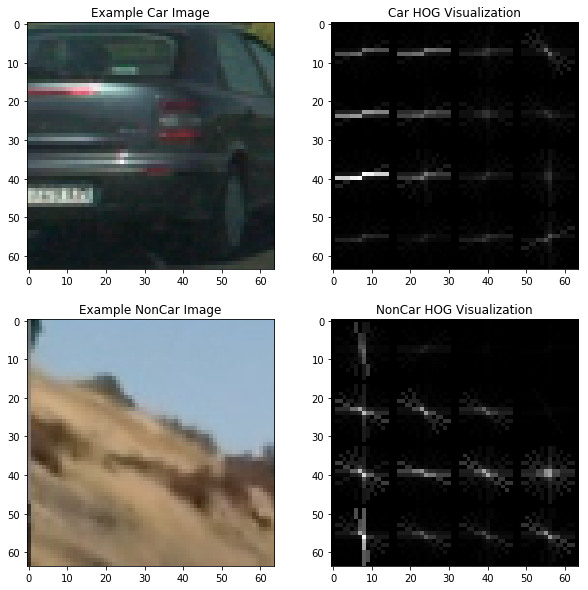

In [4]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
car_image = mpimg.imread(cars[ind])
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
noncar_image = mpimg.imread(notcars[ind])
noncar_gray = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 11
pix_per_cell = 16
cell_per_block = 2
# Call our function with vis=True to see an image output
car_features, car_hog_image = get_hog_features(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False, TransformSqrt = True)

noncar_features, noncar_hog_image = get_hog_features(noncar_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False, TransformSqrt = True)

# Plot the examples
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.subplot(221)
plt.imshow(car_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(222)
plt.imshow(car_hog_image, cmap='gray')
plt.title('Car HOG Visualization')

plt.subplot(223)
plt.imshow(noncar_image, cmap='gray')
plt.title('Example NonCar Image')
plt.subplot(224)
plt.imshow(noncar_hog_image, cmap='gray')
plt.title('NonCar HOG Visualization')


### Extract features from input datasets for training and testing: combine features, normalize, define Y labels, shuffle and split

In [5]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

t_start =time.time()
#get car features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

#get non-car features
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t_end = time.time()
print(round(t_end-t_start, 2), 's to extract all features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)   

X_scaler = []

# Apply Normalization if either of color space feature or histogram feature is required
if spatial_feat == True or hist_feat == True:
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
else:
    # Do not apply feature normalization if only HOG features are required. 
    scaled_X = X

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

184.79 s to extract all features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


### Train a Classifier

In [6]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
samples_to_predict = 20
print('SVC predicttions:', svc.predict(X_test[0:samples_to_predict]))
print('True lables     :', y_test[0:samples_to_predict])
t2 = time.time()
print('SVC takes', round(t2-t, 5), 's to predict', samples_to_predict,'labels')

3.3 Seconds to train SVC...
Test Accuracy of SVC =  0.9856
SVC predicttions: [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.
  1.  0.]
True lables     : [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.
  1.  0.]
SVC takes 0.01101 s to predict 20 labels


In [7]:
# Lesson codes.. but modified a bit
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
              color_space, hog_channel, CellsPerStep, spatial_feat, hist_feat, all_search_Boxes):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    #print(img_tosearch.shape)
    
    # This array lists all boxes where cars will be detected
    boxes = []
    
    # apply color conversion if other than 'RGB'
    TransformSquareRoot = True
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
            TransformSquareRoot = False
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
            TransformSquareRoot = False
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
            TransformSquareRoot = False
    else: ctrans_tosearch = np.copy(img_tosearch)  
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 #cell_per_block
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = CellsPerStep  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False, TransformSqrt = TransformSquareRoot)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False, TransformSqrt = TransformSquareRoot)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False, TransformSqrt = TransformSquareRoot)
    else: 
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False, TransformSqrt = TransformSquareRoot)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            hog_features = []
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                   
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color and histogram features only if required, else they will be null
            spatial_features = []
            hist_features = []
            if spatial_feat == True:
                spatial_features = bin_spatial(subimg, size=spatial_size)
            if hist_feat == True:
                hist_features = color_hist(subimg, nbins=hist_bins)
            
            finalfeatures = []           
            #Select final features based on what is required
            if spatial_feat == True & hist_feat == True:
                finalfeatures = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            elif spatial_feat == False & hist_feat == True:
                finalfeatures = np.hstack((hist_features, hog_features)).reshape(1, -1)
            elif spatial_feat == True & hist_feat == False:
                finalfeatures = np.hstack((spatial_features, hog_features)).reshape(1, -1)
            elif spatial_feat == False & hist_feat == False:
                finalfeatures = hog_features
            
            # Do not apply feature normalization if only HOG features are required. 
            # Apply Normalization if either of color space feature or histogram feature is required
            if spatial_feat == True or hist_feat == True:
                # Scale features and make a prediction
                test_features = X_scaler.transform(finalfeatures) 
            else:
                test_features = hog_features      
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or all_search_Boxes:
                xbox_left = np.int(xleft*scale) + xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                            
    return boxes

11 boxes within which cars/car parts may be present


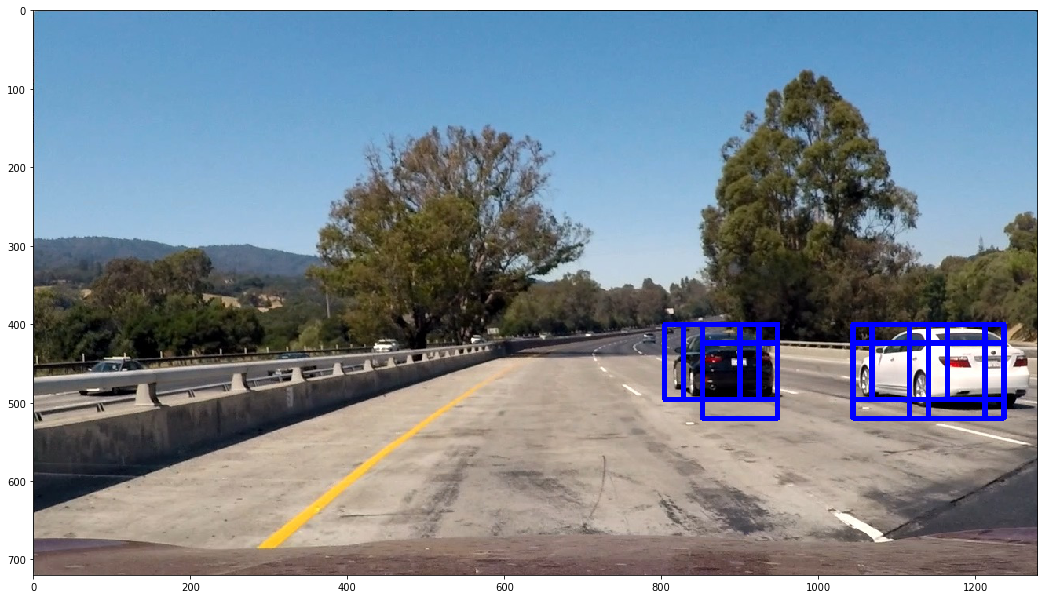

In [8]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 660
scale = 1.5
CellsPerStep = 1 # block steps for sub-sampling

# Let us assume there is some sensor which identifies which lane the vehicle is going
# If the vehicle is going in left most lane, vehicles will be on right side. So set 'xtstart' variable to 300. This saves search time. 
# If the car is in right most lane, xstop can be 'test_img.shape[1]-300' and xstart = 0
# if in middle lanes, xstart = 0, xstop = test_img.shape[1] --> Search the entire dimension, vehicles can be on either sides
xstart = 300
xstop = test_img.shape[1]

boxes = find_cars(test_img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, hog_channel, CellsPerStep, spatial_feat, hist_feat, all_search_Boxes = False)

print(len(boxes), 'boxes within which cars/car parts may be present')

window_img = draw_boxes(test_img, boxes, color=(0, 0, 255), thick=5) 
plt.figure(figsize=(18,18))
plt.imshow(window_img)



### Defining my search areas

Total number of search boxes:  1172


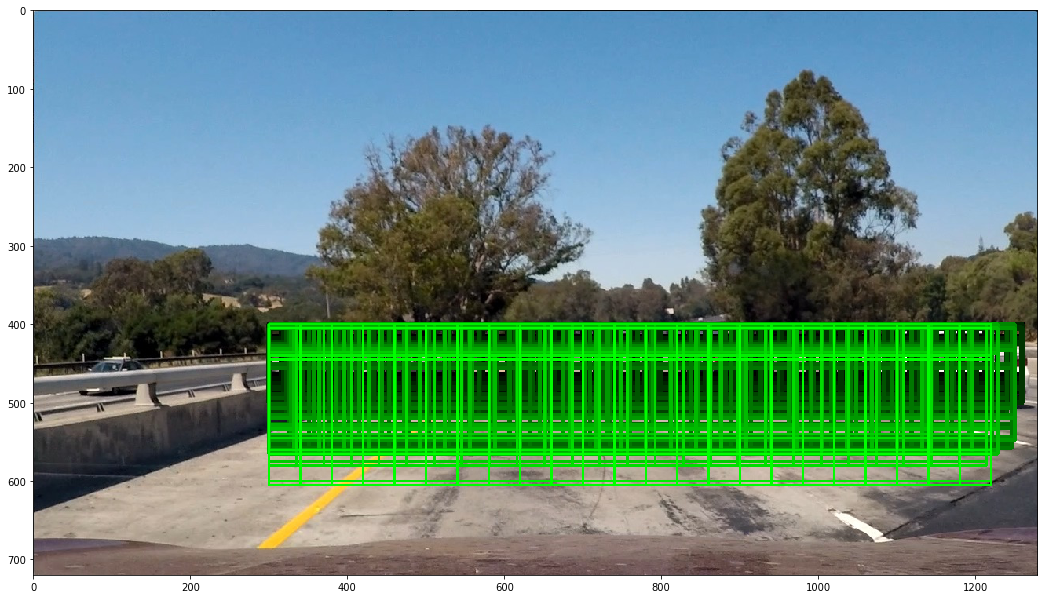

In [9]:
test_img = mpimg.imread('./test_images/test1.jpg')

totalSearchboxes = []
CellsPerStep = 1 # block steps for sub-sampling

# The following parameters define moving window search criteria

# I tried all the following...
# Less search
#ystart =[400, 420, 400, 420, 400, 400]
#ystop = [520, 540, 580, 600, 620, 660]
#scale = np.array([1.2, 1.2, 1.6, 1.6, 2.0, 2.5])

# Medium search
#ystart =[400, 410, 400, 410, 400, 410, 400, 410]
#ystop = [520, 530, 580, 590, 600, 610, 660, 670]
#scale = np.array([1.2, 1.2, 1.6, 1.6, 2.0, 2.0, 2.5, 2.5])

# even more search
#ystart =[400, 405, 400, 405, 400, 405, 400, 405, 400, 405, 400, 405, 400, 405, 400, 405, 400, 405]
#ystop = [550, 555, 570, 575, 540, 545, 580, 585, 580, 585, 600, 605, 640, 645, 660, 665, 695, 700]
#scale = np.array([1.0, 1.0, 1.2, 1.2, 1.4, 1.4, 1.6, 1.6, 1.8, 1.8, 2.0, 2.0, 2.2, 2.2, 2.5, 2.5, 3.0, 3.0])

# My final choice...
ystart =[400, 405, 400, 405, 400, 405, 400, 405, 400, 405, 400, 405, 400, 405, 400, 405]
ystop = [500, 505, 520, 525, 540, 545, 580, 585, 580, 585, 600, 605, 640, 645, 660, 665]
scale = np.array([1.0, 1.0, 1.2, 1.2, 1.4, 1.4, 1.6, 1.6, 1.8, 1.8, 2.0, 2.0, 2.2, 2.2, 2.5, 2.5])

# Show all search boxes
for k in range(len(ystop)):
    boxes = (find_cars(test_img, ystart[k], ystop[k], xstart, xstop, scale[k], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, hog_channel, CellsPerStep, spatial_feat, hist_feat, all_search_Boxes = True))
    test_img = draw_boxes(test_img, boxes, color=(0, 17*k, 0), thick=5-k//4)
    totalSearchboxes.append(boxes)
    
allboxes = [item for sublist in totalSearchboxes for item in sublist] 
print('Total number of search boxes: ', len(allboxes))
plt.figure(figsize=(18,18))
plt.imshow(test_img)



### Getting multiple detections in the boxes defined above

Detected search boxes:  114


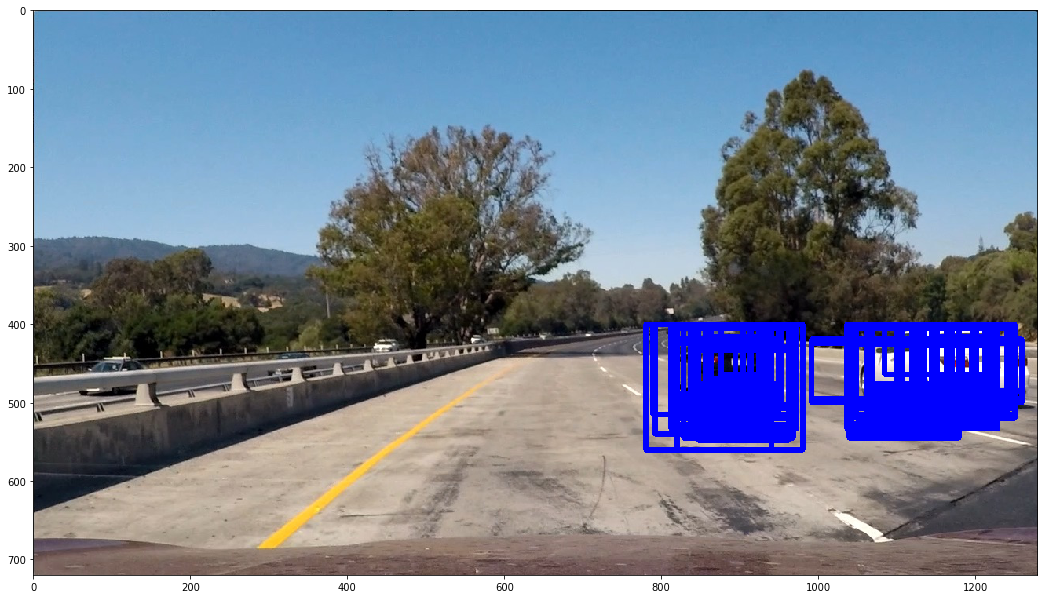

In [10]:
test_img = mpimg.imread('./test_images/test1.jpg')

totalboxes = []

# Get the search result
for k in range(len(ystop)):
    boxes = (find_cars(test_img, ystart[k], ystop[k], xstart, xstop, scale[k], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, hog_channel, CellsPerStep, spatial_feat, hist_feat, all_search_Boxes = False))
    totalboxes.append(boxes)
    
detectedboxes = [item for sublist in totalboxes for item in sublist] 
print('Detected search boxes: ', len(detectedboxes))
test_img_withBox = draw_boxes(test_img, detectedboxes, color=(0, 0, 255), thick=6)
plt.figure(figsize=(18,18))
plt.imshow(test_img_withBox)

### Heatmap on the above picture

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

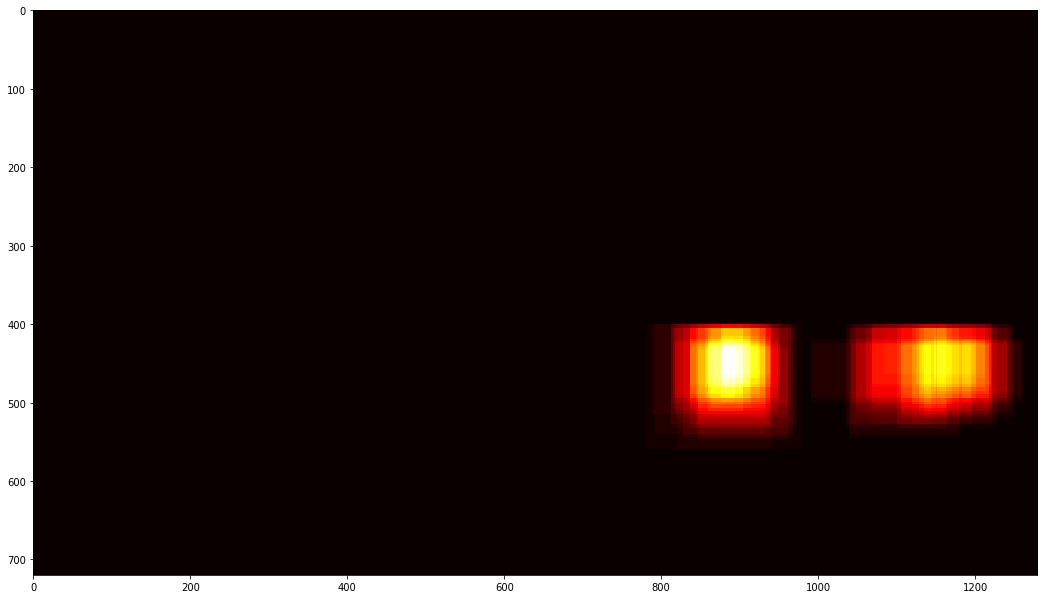

In [12]:
# Test out the heatmap
heatmap_img_unfiltered = np.zeros_like(test_img[:,:,0])
heatmap_img_unfiltered = add_heat(heatmap_img_unfiltered, detectedboxes)
plt.figure(figsize=(18,18))
plt.imshow(heatmap_img_unfiltered, cmap='hot')

### Threshold based Heatmap

In [13]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

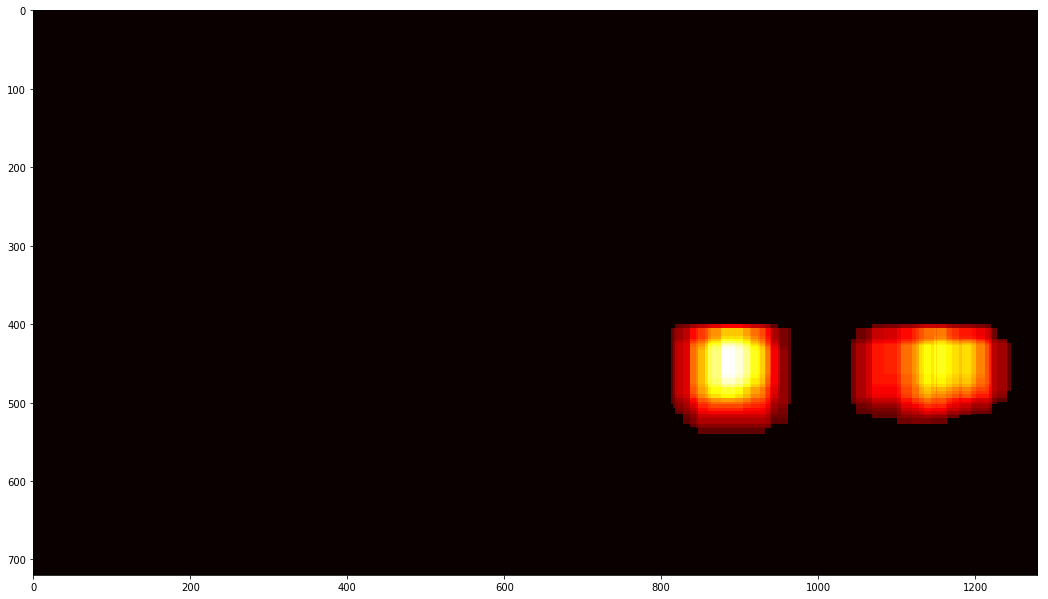

In [14]:
heatmap_img = []
heatmap_img = apply_threshold(heatmap_img_unfiltered, 6)
plt.figure(figsize=(18,18))
plt.imshow(heatmap_img, cmap='hot')


###  Labeling the Heatmap

2 cars found


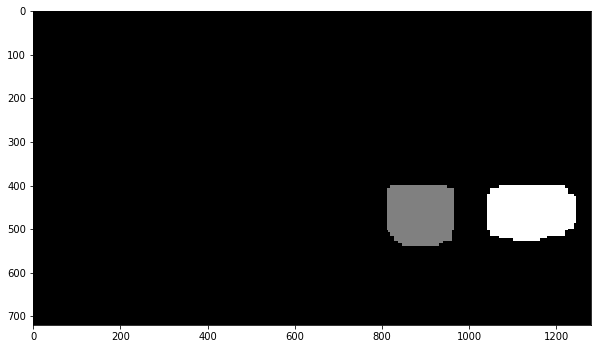

In [15]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

In [16]:
# Define a class to store previous labeled boxes in a video stream
class Detected_Boxes():
    def __init__(self):
        # past boxes
        self.previous_searches = [] 
        
    def append_boxes(self, boxes):
        self.previous_searches.append(boxes)
        if len(self.previous_searches) > 5:
            # remove anything thats saved 5 frames ago 
            self.previous_searches = self.previous_searches[len(self.previous_searches)-5:]

In [17]:
det_box = Detected_Boxes()
det_box.previous_searches = []

### Draw boxes on labeled image

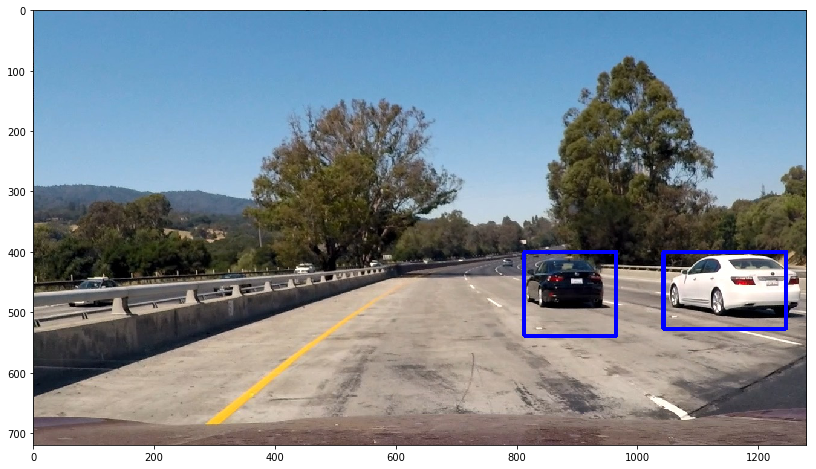

In [18]:
def draw_labeled_bboxes(img, labels):
    labelbox = []
    temp_rect = []
        
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        labelbox.append(bbox)
   
    #store the current box that you just obtained
    det_box.append_boxes(labelbox)  
    
    # Once you have the labelbox for all cars/labels, next step is to do the 'moving average' of boxes for each cars/labels
    if len(det_box.previous_searches) > 0 and labels[1] > 0:
        
        #iterate through each car
        for car_number in range(1, labels[1]+1): 
            
            #setup variables to copy current and previous boxes
            # these variables catch the two diagonal corners of the box
            a = []
            b = []
            c = []
            d = []
            
            for k in range(len(det_box.previous_searches)):
                try:
                    a.append(det_box.previous_searches[k][car_number-1][0][0])
                    b.append(det_box.previous_searches[k][car_number-1][0][1])
                    c.append(det_box.previous_searches[k][car_number-1][1][0])
                    d.append(det_box.previous_searches[k][car_number-1][1][1])
                except IndexError:
                    donothing = 1
                    
            todivide = len(a)
            
            #these variables will have two diagonal corners of the 'averaged' box: (x1, y1), (x2, y2)
            a2 = np.sum(a)//todivide # gets x1
            b2 = np.sum(b)//todivide # gets y1
            c2 = np.sum(c)//todivide # gets x2
            d2 = np.sum(d)//todivide# gets y2
            
            bbox2 = ((a2, b2), (c2, d2))
            temp_rect.append(bbox2)
            
        det_box.previous_searches = det_box.previous_searches[0:len(det_box.previous_searches)-1] #removing the last item
        det_box.append_boxes(temp_rect) # replace with the 'smoothed' box
        
    else:
        
         #removing the last item because 'null' was appended        
        det_box.previous_searches = det_box.previous_searches[0:len(det_box.previous_searches)-1]
        
        #instead of showing no box, show'smoothed' box from the previous frame because vehicle position would not have changed much
        try:
            temp_rect = det_box.previous_searches[len(det_box.previous_searches)-1]
        except IndexError:
            temp_rect = []
           
    for car_number in range(1, labels[1]+1):
    # Draw the box on the image
        cv2.rectangle(img, (temp_rect[car_number-1][0][0],temp_rect[car_number-1][0][1]), (temp_rect[car_number-1][1][0],temp_rect[car_number-1][1][1]), (0,0,255), 6)
    
    # Return the image and final rectangles
    return img

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(18,8))
plt.imshow(draw_img)


### Pipeline for processing one frame

In [19]:
def process_one_frame(img):
    #define search boxes
    totalboxes = []
    for k in range(len(ystop)):
        boxes = (find_cars(img, ystart[k], ystop[k], xstart, xstop, scale[k], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, hog_channel, CellsPerStep, spatial_feat, hist_feat, all_search_Boxes = False))
        totalboxes.append(boxes)
    
    #get all detected boxes
    detectedboxes = [item for sublist in totalboxes for item in sublist] 
    
    #get heatmap
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, detectedboxes)
    
    #apply threshold to heatmap
    heatmap_img = apply_threshold(heatmap_img,3)
    
    #label the heatmap
    labels = label(heatmap_img)      
    
    #draw boxes on labels and get the image with boxes
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

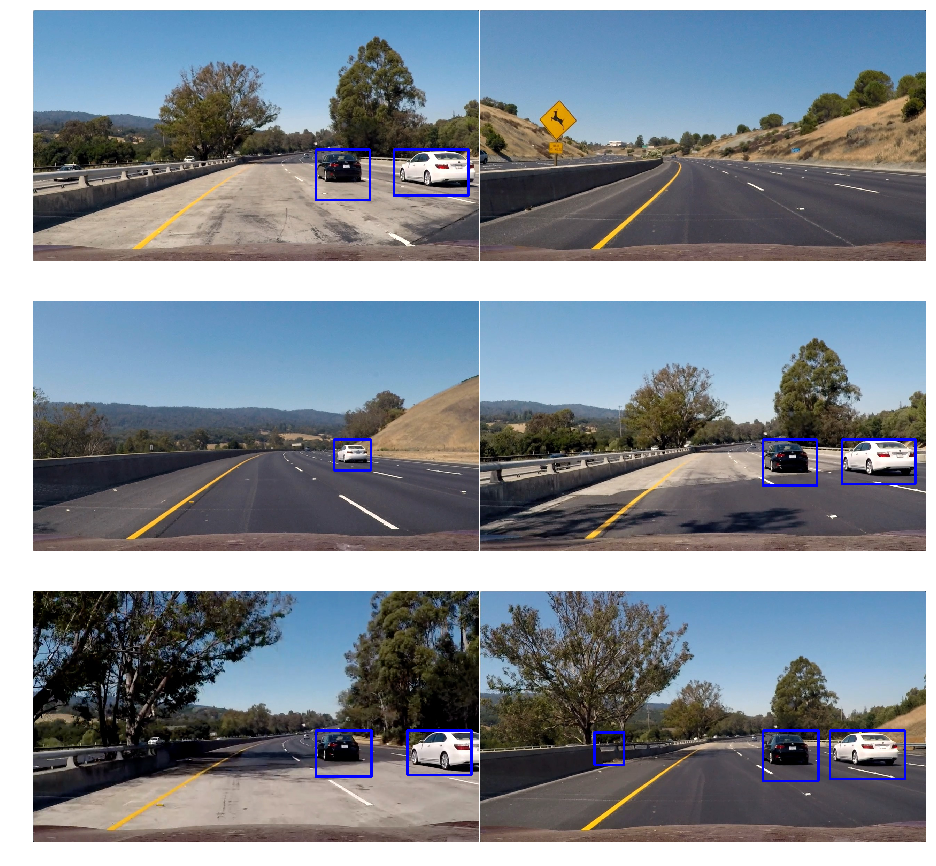

In [20]:
test_images = glob.glob('./test_images/test*.jpg')

det_box = Detected_Boxes()
det_box.previous_searches = []

#testing on 6 test images
fig, axs = plt.subplots(3, 2, figsize=(16,16))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_one_frame(mpimg.imread(im)))
    axs[i].axis('off')
    # I dont want to store previous windows for test images
    det_box.previous_searches = []

In [21]:
det_box = Detected_Boxes()
det_box.previous_searches = []

#testing on test video
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_one_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 38/39 [01:37<00:02,  2.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 1min 39s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [23]:
#testing on project video
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_one_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [48:28<00:02,  2.32s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 48min 30s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))